####IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, Dataset
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import random
import sys
from torch import optim
import cv2
import tensorflow as tf
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from scipy.ndimage import map_coordinates, gaussian_filter
from tensorflow.keras.callbacks import EarlyStopping
from torchvision import transforms
from torchvision.transforms.functional import vflip
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import rotate
from PIL import Image

###Data input and storage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/contest/'

Mounted at /content/drive


In [ ]:
train_amp_images = []
train_phase_images = []
train_merged_images = []
train_gt = []
contest_test_amp_images = []
contest_test_phase_images = []
contest_test_merged_images = []

def merge_images(amplitude, phase):
    # Check if amplitude and phase have the same shape
    assert amplitude.shape == phase.shape, "Amplitude and phase images must have the same dimensions"

    # Concatenate amplitude and phase along the channel dimension
    merged = []
    merged.append(amplitude)
    merged.append(phase)
    merged_image = np.stack(merged , 0)
    merged_image = merged_image.transpose(1,2,0)

    return merged_image

def create_npy_files(data_path, output_path):
    train_data_path = os.path.join(data_path, 'train_data')
    train_filenames = sorted(os.listdir(train_data_path))

    test_data_path = os.path.join(data_path, 'test_data')
    test_filenames = sorted(os.listdir(test_data_path))

    # Create train data npy files
    for filename in train_filenames:
        if filename.endswith(".bmp"):
            amp_path = os.path.join(train_data_path, filename)
            amp = cv2.imread(amp_path) #big diff
            amp = cv2.cvtColor(amp , cv2.COLOR_BGR2GRAY)
            train_amp_images.append(amp)
        elif filename.endswith(".tiff"):
            phase_path = os.path.join(train_data_path, filename)
            phase = cv2.imread(phase_path) #big diff
            phase = cv2.cvtColor(phase, cv2.COLOR_BGR2GRAY)
            train_phase_images.append(phase)
        elif filename.endswith(".png"):
            gt_path = os.path.join(train_data_path, filename)
            gt = cv2.imread(gt_path)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
            train_gt.append(gt)
        else:
            print('Error: don\'t know what to do')
    # Merging
    train_merged_images = [merge_images(amp, phase) for amp, phase in zip(train_amp_images, train_phase_images)]


    # Create output directory
    os.makedirs(output_path, exist_ok=True)

    #Apply augmentation, inflate the dataset
    train_gt_aug=[]
    train_merged_aug = []
    assert len(train_merged_images) == len(train_gt)

    for j in range(len(train_merged_images)):
        for i in range(4):
          train_gt_aug.append(np.array(augment(train_gt[j], i)))
          tmp = np.array(augment(train_merged_images[j] , i))
          train_merged_aug.append(tmp/255)

    for i in range(len(train_gt_aug)):
      tmp = train_gt_aug[i]
      mask_indices = np.zeros((128,128))
      mask_indices[(tmp[:, :, 0] == 255) & (tmp[:, :, 1] == 0) & (tmp[:, :, 2] == 0)] = 1  # Red
      mask_indices[(tmp[:, :, 0] == 0) & (tmp[:, :, 1] == 255) & (tmp[:, :, 2] == 0)] = 2  # Green
      mask_indices[(tmp[:, :, 0] == 0) & (tmp[:, :, 1] == 0) & (tmp[:, :, 2] == 255)] = 3  # Blue
      train_gt_aug[i] = mask_indices
    # Save npy files using full paths and show the number
    np.save(os.path.join(output_path, 'train_gt.npy'), (train_gt_aug))
    np.save(os.path.join(output_path, 'train_merged_images.npy'), (train_merged_aug))


    print(f"Number of images in train_data GT: {len(train_gt_aug)}")
    print(f"Number of images in train_data Merged: {len(train_merged_aug)}")
    # Create test data npy files
    for filename in test_filenames:
        if filename.endswith(".bmp"):
            amp_path = os.path.join(test_data_path, filename)
            amp = cv2.imread(amp_path) #big diff
            amp = cv2.cvtColor(amp, cv2.COLOR_BGR2GRAY)
            contest_test_amp_images.append(amp)
        elif filename.endswith(".tiff"):
            phase_path = os.path.join(test_data_path, filename)
            phase = cv2.imread(phase_path) #big diff
            phase = cv2.cvtColor(phase, cv2.COLOR_BGR2GRAY)
            contest_test_phase_images.append(phase)
        else:
            print('Error: don\'t know what to do')

    # Merging (separate function could be used if called twice)
    contest_test_merged_images = [merge_images(amp, phase) for amp, phase in zip(contest_test_amp_images, contest_test_phase_images)]
    print(f"Number of images in test_data merged: {len(contest_test_merged_images)}")

    # Save test data npy files using full paths
    np.save(os.path.join(output_path, 'contest_test_merged_images.npy'), (contest_test_merged_images), allow_pickle=True)


In [ ]:
def augment(img,i):
  img = Image.fromarray(img)
  if i == 0:
    img = vflip(img)
    img = rotate(img, 90)
  if i == 1:
    img = hflip(img)
    img = rotate(img, 90)
  if i == 2:
    img = rotate(img, -90)
  if i == 3:
    img = vflip(img)
    img = rotate(img, -180)
  return img

In [ ]:
data_path = 'drive/MyDrive/contest/'
output_path = 'drive/MyDrive/contest/npy_files/'
create_npy_files(data_path, output_path)


Number of images in train_data GT: 728
Number of images in train_data Merged: 728
Number of images in test_data merged: 64


####Dataloader

In [ ]:
def load_data(path):
    path = path + "npy_files/"
    train_gt = np.load(os.path.join(path, 'train_gt.npy'))
    train_merged_images = np.load(os.path.join(path, 'train_merged_images.npy'))
    contest_test_merged_images = np.load(os.path.join(path, 'contest_test_merged_images.npy'))

    return (
        train_gt,
        train_merged_images,
        contest_test_merged_images
    )

In [ ]:
train_gt, train_merged_images, contest_test_merged_images = load_data(folder_path)

In [ ]:
####TODO - shape is legyen 4d

print(f"Train Ground Truth Image Shape: {train_gt[1].shape}")
print(f"Train Merged Image Shape: {train_merged_images[1].shape}")
print(f"Test Merged Shape: {contest_test_merged_images[1].shape}")


Train Ground Truth Image Shape: (128, 128)
Train Merged Image Shape: (128, 128, 2)
Test Merged Shape: (128, 128, 2)


###Data augment

###Dataset + combining the masks to 1 channel (B = 0 , R=1 ,G=2 , B=3) + getnextbatch

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, mask = self.data[idx], self.labels[idx]



        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)



            # Create an empty tensor with the desired shape
        mask_tensor = np.zeros((128, 128), dtype=np.uint8)
          # Replace non-dominant pixels (excluding black) with black
        mask = np.swapaxes(mask, -1 ,0)
        for i in range(mask.shape[0]):
           for j in range(mask.shape[1]):
            pixel = mask[i, j]
            if np.array_equal(pixel, [0, 0, 0]):
                mask_tensor[i, j] = 0
            elif np.array_equal(pixel, [255, 0, 0]):
                mask_tensor[i, j] = 1
            elif np.array_equal(pixel, [0, 255, 0]):
                mask_tensor[i, j] = 2
            elif np.array_equal(pixel, [0, 0, 255]):
                mask_tensor[i, j] = 3


      # Transpose the tensor to match your desired shape
        #mask_tensor = np.swapaxes(mask_tensor, 0, 2)

        return {'image': img, 'mask': mask_tensor}
# Create CustomDataset instances for validation

In [ ]:
def get_next_batch(img, mask, batch_number):
  assert(len(img) == len(mask))

  used_in_batch = random.sample(range(len(img)), batch_number)
  imgs = img[used_in_batch, :]
  masks = mask[used_in_batch]
  imgs = torch.from_numpy(imgs)
  masks = torch.from_numpy(masks)

  return imgs, masks

###U-net

In [ ]:
# DOUBLECONV
# We are using DoubleConv In many places in the architechture. So first we will define this one.
# This will be the class double conv
class DoubleConv(nn.Module): # If we want to use a class as a building block of an architechture the we have to inherit nn.Module
    def __init__(self, in_channels, out_channels):
        super().__init__() # First we have to initialize the ancestor
        self.double_conv = nn.Sequential( # nOW WE WILL define the double_conv which will contain the 2 convolutions with batchnorm
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

#TODO DOWN
# First lets define a class for creating downsampling layers:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels): # This will wait for two inputs: the number of in_channels and ...
        super().__init__()
        self.maxpool_conv = nn.Sequential( # After we will define maxpool_conv which consist of a..
            DoubleConv(in_channels, out_channels),
            nn.MaxPool2d(2)
        )
    def forward(self, x): # In the forward prop we will apply this on the input x.
        return self.maxpool_conv(x)

#TODO UP
# After lets define a class for UP layers
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__() # First we have to initialize the ancestor

        # After lets define the parts of up layer. In this we have
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            #the floor division // rounds the result down to the nearest whole number
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2): # In the forward prop we have two inputs: one is coming from down (x1) and one
                               # is coming from the skip connection (x2)
        x1 = self.up(x1) # We will apply the transpose conv o the x1

        # NOw we will calculate what is the difference in x and y direction btween the size of x1 and x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        # It is important to calculate how mutch padding we needin the different
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        # wITH TORCH cat we can concatenate the two tensor
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

#TODO outCONV
# Finally we will define a class for the outCon which
# will take us back to the out_channel num.
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# NET
class Net(nn.Module):
  def __init__(self, i_ch_n, o_ch_n):
          super().__init__()

          #parameters
          self.input_channel_num = i_ch_n
          self.output_channel_num = o_ch_n

          #downscaling layers
          self.inc = DoubleConv(self.input_channel_num, 64)
          self.down1= Down(64,128)
          self.down2= Down(128,256)
          self.down3= Down(256,512)
          self.down4= Down(512,1024)

          #upscalin layers
          self.up1 = Up(1024,512)
          self.up2 = Up(512,256)
          self.up3 = Up(256,128)
          self.up4 = Up(128,64)
          self.outconv = OutConv(64, self.output_channel_num)


  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5,x4)
    x = self.up2(x,x3)
    x= self.up3(x,x2)
    x= self.up4(x,x1)
    outp = self.outconv(x)
    return outp

In [ ]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_prob)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            DoubleConv(in_channels, out_channels, dropout_prob),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.2):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, dropout_prob)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Net(nn.Module):
    def __init__(self, i_ch_n, o_ch_n, dropout_prob=0.2):
        super().__init__()

        self.input_channel_num = i_ch_n
        self.output_channel_num = o_ch_n

        self.inc = DoubleConv(self.input_channel_num, 64, dropout_prob)
        self.down1 = Down(64, 128, dropout_prob)
        self.down2 = Down(128, 256, dropout_prob)
        self.down3 = Down(256, 512, dropout_prob)

        # Reduce the complexity by removing the fourth down layer and corresponding up layer
        self.up1 = Up(512, 256, dropout_prob)
        self.up2 = Up(256, 128, dropout_prob)
        self.up3 = Up(128, 64, dropout_prob)

        self.outconv = OutConv(64, self.output_channel_num)

        self.bn = nn.BatchNorm2d(self.input_channel_num)  # Adding BatchNorm layer for input normalization

    def forward(self, x):
        x = self.bn(x)  # Applying BatchNorm to input

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)

        outp = self.outconv(x)
        return outp


In [ ]:
model = Net(2,4)
#print(model)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,702,600 trainable parameters


#Training

##Train procedure, params, optim ,loss fs, early stopper and the training loop

In [ ]:
# train parameters
epochs=600
batch_size = 32
lr=0.0005

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 0.2)
# Initialize the scheduler, specifying the optimizer and mode (min for loss)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=True)

model = model.to(device)
criterion = criterion.to(device)
#val_criterion = val_criterion.to(device)
# Create DataLoader for validation
#valid_dataset = CustomDataset(valid_data, valid_labels,transform=transforms.ToTensor())
#valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"Paramteres_of_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}"
pth_path = "drive/MyDrive/contest/"
print(f"results_lr{lr}_epochs{epochs}_batch{batch_size}_{timestamp}")

# List to store training losses during each epoch
losses = []
#val_losses = []
lr_s = []
counter = 0
patience = 60
# Variable to keep track of the best validation loss
best_val_loss = float('inf')
best_train_loss = float('inf')


#Training loop
for epoch in range(epochs):
    epoch_loss = 0  # Initialize the training loss for the current epoch
    model.train()   # Set the model to training mode

    # Create batches of images and masks for training
    imgs, true_masks = get_next_batch(train_merged_images, train_gt, batch_size)


    # Move data to the specified device (e.g., GPU)
    imgs = imgs.to(device=device, dtype=torch.float32)
    mask_type = torch.float32  # Specify the data type for masks (float for regression)
    true_masks = true_masks.to(device=device, dtype=mask_type)
    imgs = imgs.permute(0,3,1,2)
    # Forward pass: Run the network on the current batch
    masks_pred = model(imgs)

    # Compute the loss between predicted masks and true masks
    #print(masks_pred.shape)  # Check the shape of masks_pred
    #print(true_masks.shape)

    loss = criterion(masks_pred, true_masks.long())
    epoch_loss += loss.item()  # Accumulate the loss for the current batch

    # Backward pass: Calculate gradients and update model parameters
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Backpropagation
    nn.utils.clip_grad_value_(model.parameters(), 0.1)  # Clip gradients to avoid exploding gradients
    optimizer.step()  # Update model parameters based on gradients

    # Step the scheduler based on the validation loss
    scheduler.step(loss)

    # Save upon lower training loss
    if loss < best_train_loss:
        best_train_loss = loss
        # Save the model parameters
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        torch.save(model.state_dict(), pth_path + filename + '_train.pth')
    else:
      counter += 1
    if epoch % 10 == 0:
      losses.append(epoch_loss)
      print("Epoch {}: Training Loss: {:.4f}".format(epoch+1, epoch_loss))
      # Print training and validation loss for monitoring
      '''
    if counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break
      '''
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))


results_lr0.0005_epochs600_batch32_2023-11-26_16-09-22
Epoch 1: Training Loss: 1.5327
Epoch 11: Training Loss: 1.0768
Epoch 21: Training Loss: 0.8286
Epoch 31: Training Loss: 0.7077
Epoch 41: Training Loss: 0.6033
Epoch 51: Training Loss: 0.5106
Epoch 61: Training Loss: 0.4260
Epoch 71: Training Loss: 0.3854
Epoch 81: Training Loss: 0.3425
Epoch 91: Training Loss: 0.3335
Epoch 101: Training Loss: 0.2908
Epoch 111: Training Loss: 0.3270
Epoch 121: Training Loss: 0.2437
Epoch 131: Training Loss: 0.2256
Epoch 141: Training Loss: 0.2578
Epoch 151: Training Loss: 0.2141
Epoch 161: Training Loss: 0.2160
Epoch 171: Training Loss: 0.2508
Epoch 00173: reducing learning rate of group 0 to 2.5000e-04.
Epoch 181: Training Loss: 0.2146
Epoch 191: Training Loss: 0.2111
Epoch 00193: reducing learning rate of group 0 to 1.2500e-04.
Epoch 201: Training Loss: 0.1789
Epoch 211: Training Loss: 0.1792
Epoch 00216: reducing learning rate of group 0 to 6.2500e-05.
Epoch 221: Training Loss: 0.1875
Epoch 231: 

<All keys matched successfully>

##Training results

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'losses' and 'val_losses' are your lists containing loss values

# Remove the first 10 values from both lists
losses_trimmed = losses[10:]

fig, ax1 = plt.subplots(figsize=(10, 8))

# Plotting trimmed training loss on the primary y-axis (left)
ax1.plot(losses_trimmed, label='Training Loss', color='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Creating a secondary y-axis
ax2 = ax1.twinx()
plt.title('Training and Validation Loss (After removing the first 10 values)')
plt.show()

##Modell betöltése egy specifik paraméterekkel

In [ ]:
model.eval()
#model.load_state_dict(torch.load(folder_path +'ezzel_probald_mar.pth',map_location=torch.device(device)))
model.load_state_dict(torch.load('/content/best_model.pth', map_location=torch.device('cpu')))


In [ ]:
imgs, true_mask = get_next_batch(train_merged_images, train_gt, batch_size)
imgs = imgs.to(device=device, dtype=torch.float32)
mask_type = torch.float32 #if net.input_channel_num == 1 else torch.long
true_masks = true_mask.to(device=device, dtype=mask_type)
imgs = imgs.permute(0,3,1,2)
masks_pred = model(imgs)

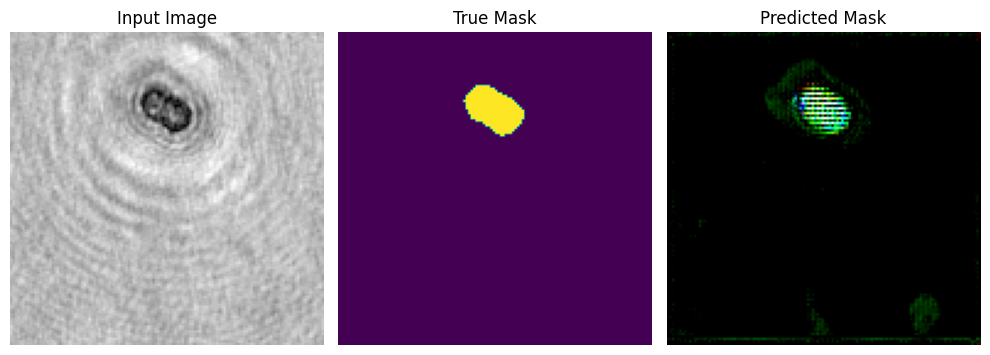

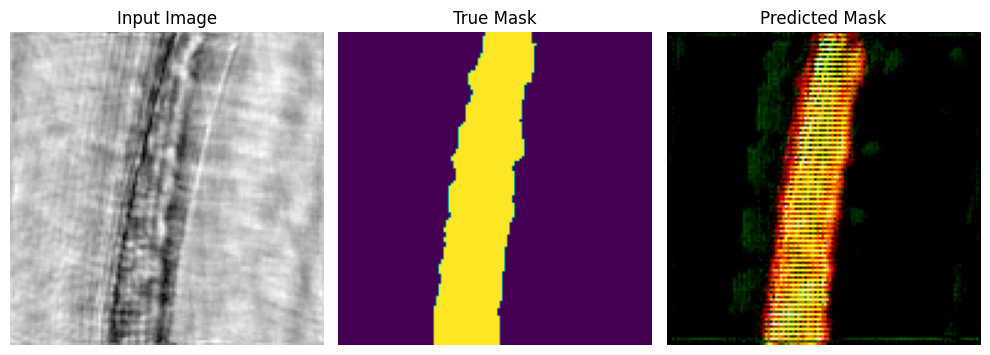

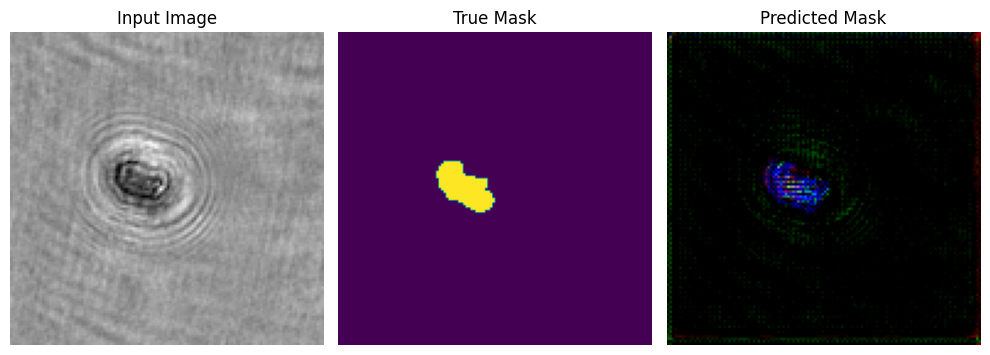

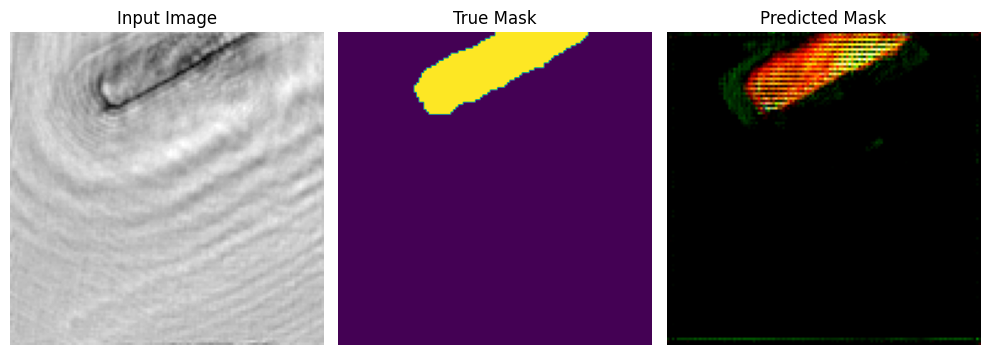

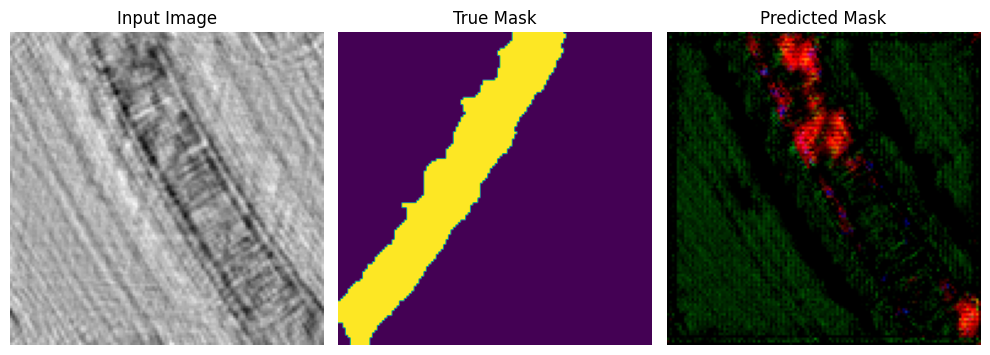

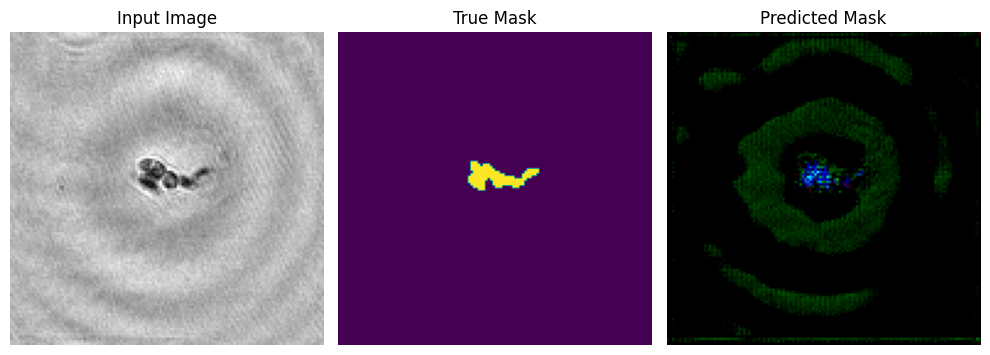

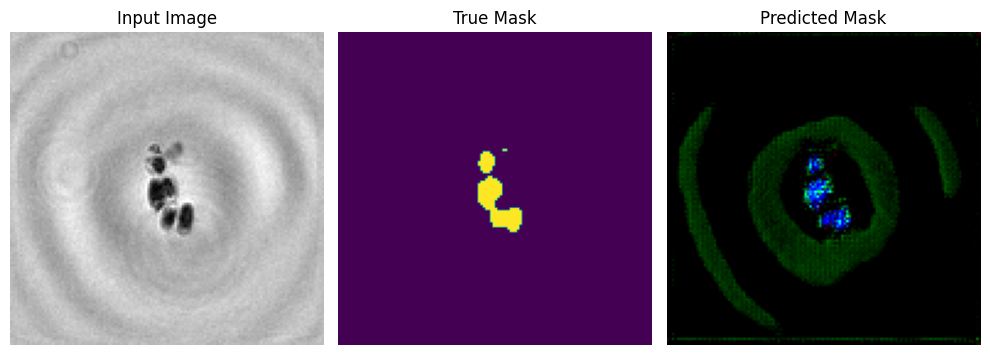

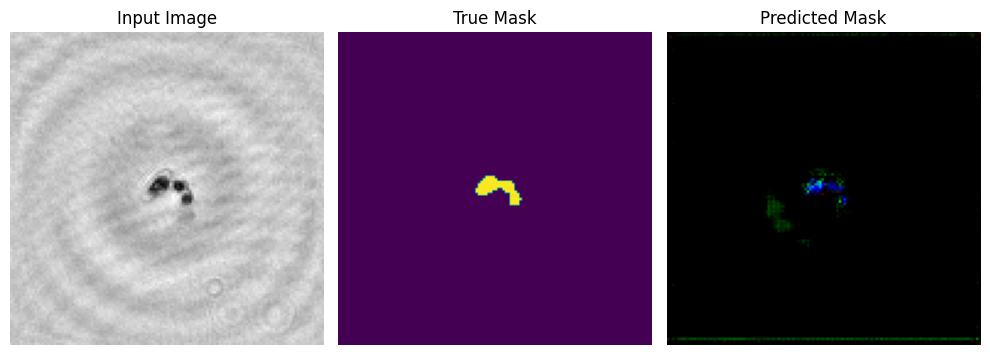

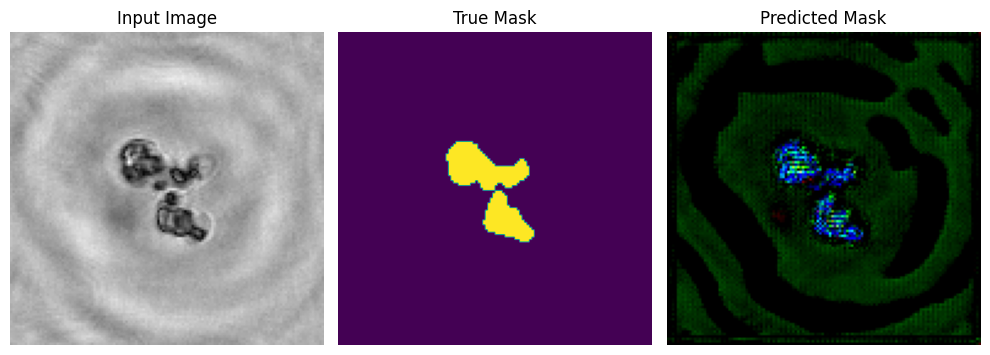

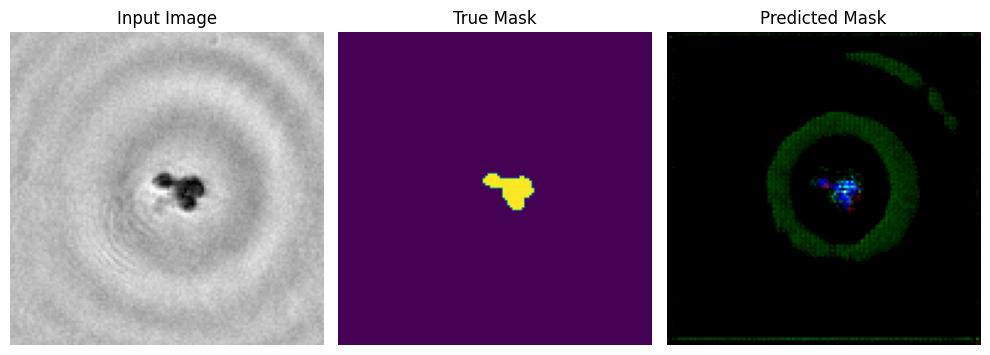

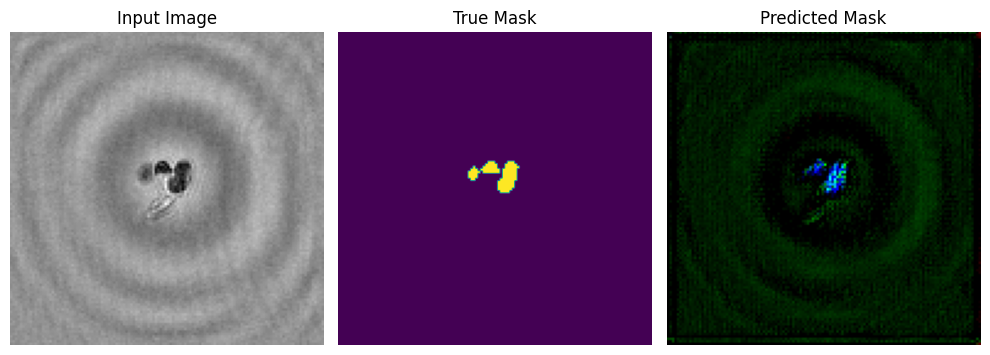

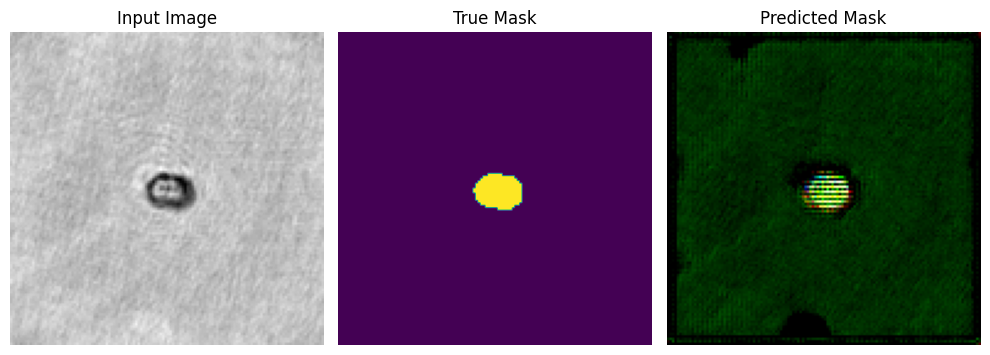

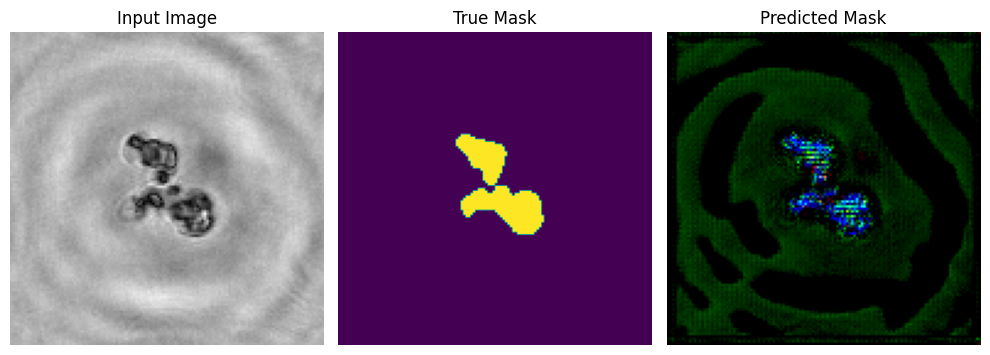

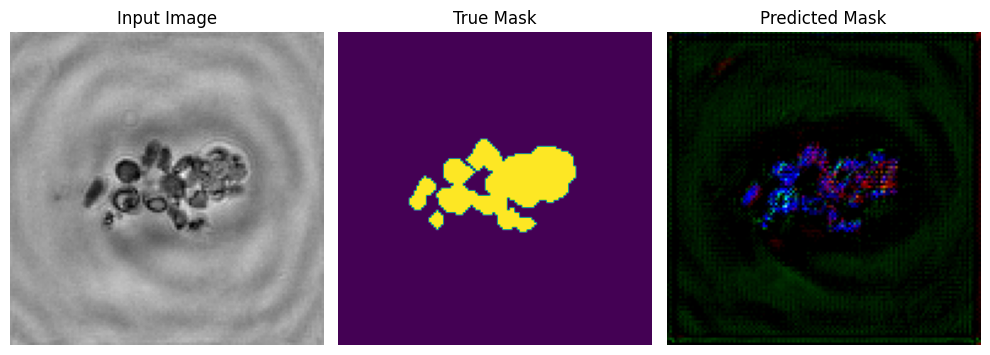

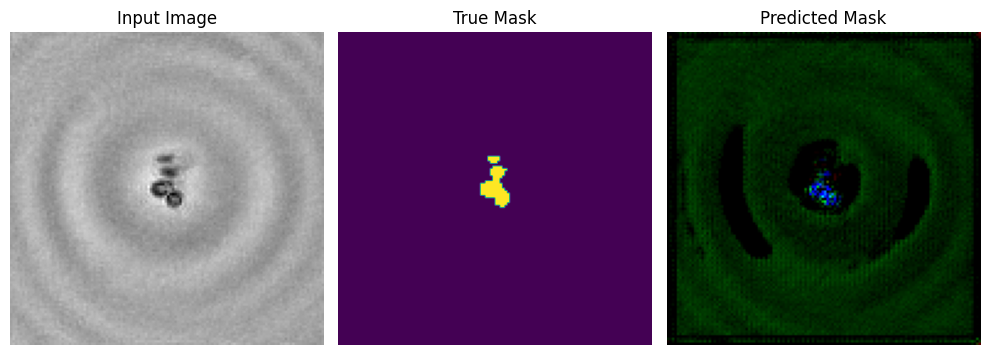

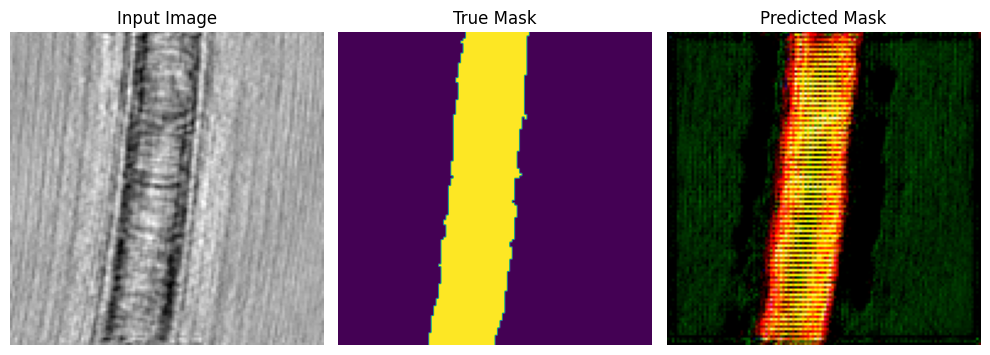

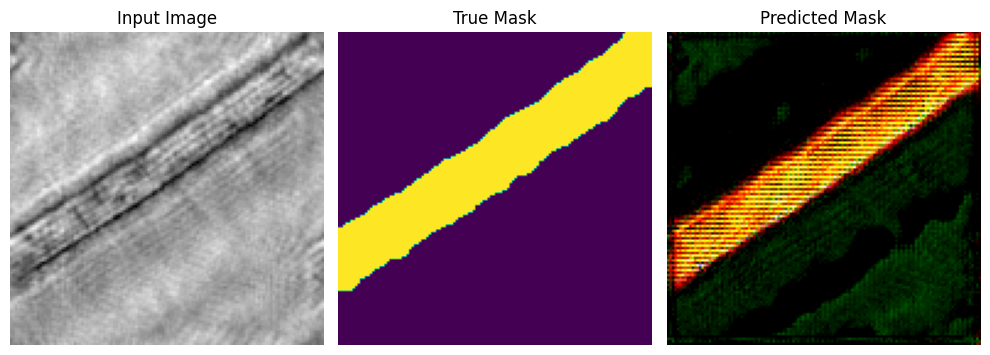

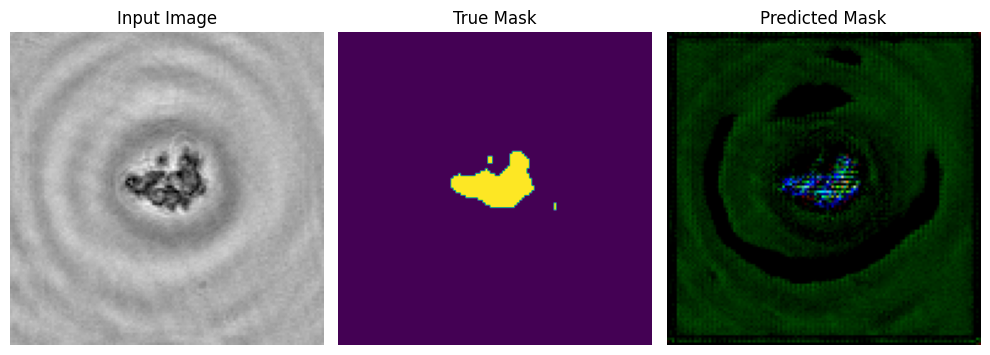

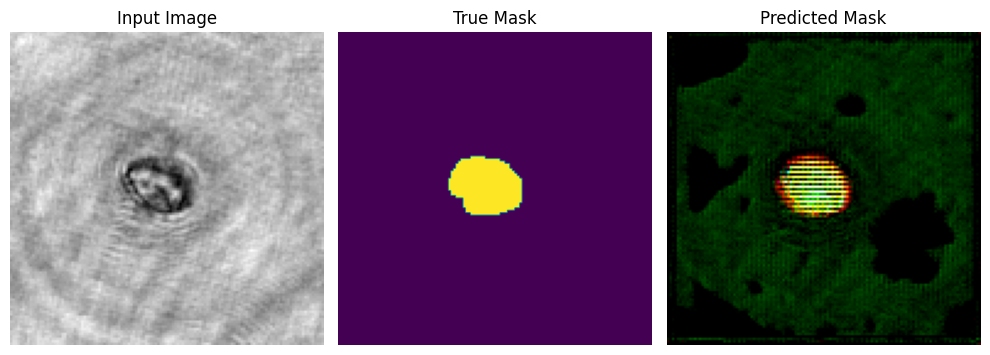

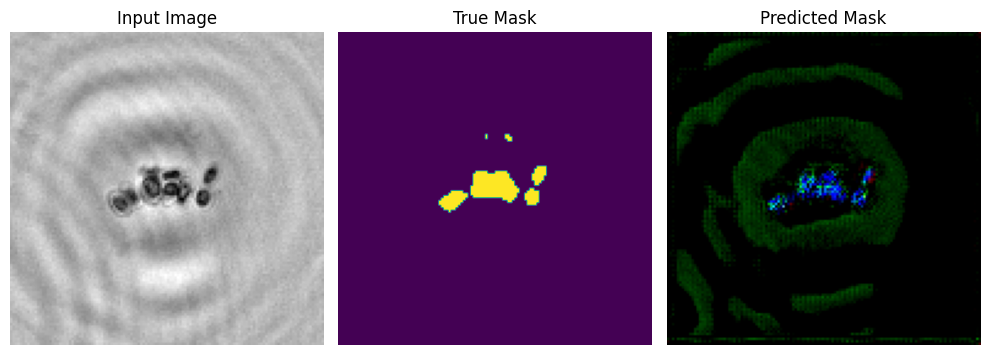

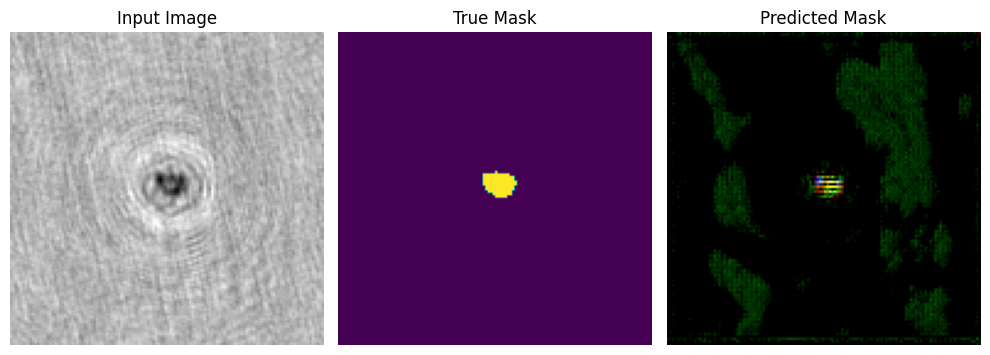

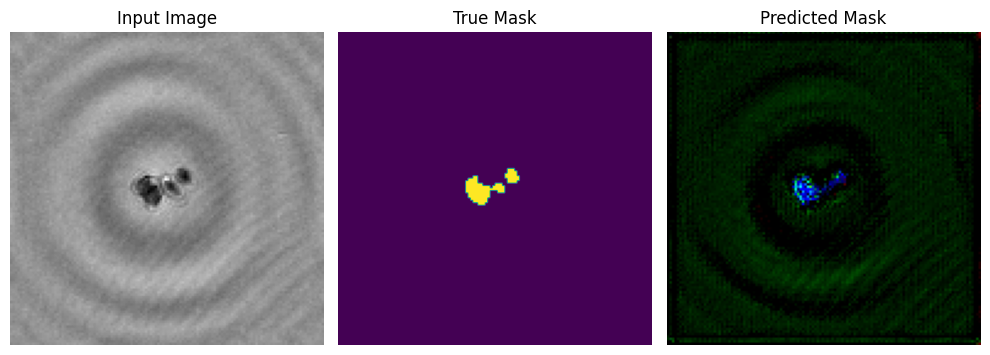

TypeError: ignored

In [ ]:
def display_side_by_side(imgs, true_masks, pred_masks):
    num_images = imgs.shape[0]

    for i in range(batch_size):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Create a figure with three subplots

        # Plot the input image
        axes[0].imshow(imgs[i][0].cpu().numpy(), cmap='gray')  # Assuming grayscale images
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        # Plot the true mask
        axes[1].imshow(true_masks[i].cpu().numpy())  # Assuming RGB mask
        axes[1].set_title('True Mask')
        axes[1].axis('off')

        # Plot the predicted mask
        axes[2].imshow(pred_masks[i].cpu().detach().numpy().transpose(1, 2, 0)[:,:,[1,2,3]])  # Assuming RGB mask
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

# Displaying the images and masks side by side
display_side_by_side(imgs, true_mask, masks_pred)
tmp = np.argmax(masks_pred(dim = 0))

###Load saved parameters

In [ ]:
#load the model whit the saved parameters
model.load_state_dict(torch.load("/content/drive/MyDrive/contest/markus.pth"))
model.eval()

Net(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
      

##Kiiratás cucc


In [ ]:
black_threshold = 0.01
color_threshold = 0.01

In [ ]:
def get_next_batch2(img, batch_length):

    used_in_batch = random.sample(range(len(img)), batch_length)
    imgs = img[used_in_batch, :]
    imgs = torch.from_numpy(imgs)
    imgs = imgs.permute(0, 3, 1, 2)
    return imgs

imgs = get_next_batch2(contest_test_merged_images, batch_size)

imgs = imgs.to(device=device, dtype=torch.float32)
imgs = imgs/255


masks_pred = model(imgs)


fig = plt.figure(figsize=(120, 140))
ax = fig.subplots(nrows=10, ncols=3)


class_colors = {
    0: (0, 0, 0),  # Background (black)
    3: (0, 0, 255),  # Red
    2: (0, 255, 0),  # Green
    1: (255, 0, 0)  # Blue
}

for i in range(10):
  img = imgs[i].cpu().detach().numpy()
  img = np.swapaxes(img,0,2)
  ax[i, 0].imshow(img[:,:,0])




  sample_outputs_argmax = torch.argmax(masks_pred[i], dim=0).cpu().numpy()
  output_image_colored = np.zeros((128, 128, 3), dtype=np.uint8)
  for class_index, color in class_colors.items():
      mask = (sample_outputs_argmax == class_index)
      output_image_colored[mask] = color

  output_image_colored = Image.fromarray(output_image_colored)
  output_image_colored = np.swapaxes(output_image_colored,1,0)

  ax[i, 1].imshow(output_image_colored)


'''
for i in range(10):
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Create a figure with three subplots


        img = imgs[i].cpu().detach().numpy()
        img = np.swapaxes(img,0,2)
        # Plot the input image
        axes[0].imshow(img[:,:,0])  # Assuming grayscale images
        axes[0].set_title('Input Image')
        axes[0].axis('off')

        domin_img = dominant_color_only(masks_pred[i])
        axes[1].imshow(domin_img)  # Assuming RGB mask
        axes[1].set_title('DOM IMG Mask')
        axes[1].axis('off')

        # Plot the predicted mask
        axes[2].imshow(masks_pred[i].cpu().detach().numpy().transpose(1, 2, 0)[:,:,[1,2,3]])  # Assuming RGB mask
        axes[2].set_title('Predicted Mask')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
'''

"\nfor i in range(10):\n        fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Create a figure with three subplots\n\n\n        img = imgs[i].cpu().detach().numpy()\n        img = np.swapaxes(img,0,2)\n        # Plot the input image\n        axes[0].imshow(img[:,:,0])  # Assuming grayscale images\n        axes[0].set_title('Input Image')\n        axes[0].axis('off')\n\n        domin_img = dominant_color_only(masks_pred[i])\n        axes[1].imshow(domin_img)  # Assuming RGB mask\n        axes[1].set_title('DOM IMG Mask')\n        axes[1].axis('off')\n\n        # Plot the predicted mask\n        axes[2].imshow(masks_pred[i].cpu().detach().numpy().transpose(1, 2, 0)[:,:,[1,2,3]])  # Assuming RGB mask\n        axes[2].set_title('Predicted Mask')\n        axes[2].axis('off')\n\n        plt.tight_layout()\n        plt.show()\n"

#Kiiratás, ide még egy select dominant color dolog kellene

In [ ]:
import cv2
import numpy as np

def most_common_color(image):
    color = np.bincount(image.flatten())
    return np.argmax(color)

# Load images

tmp = torch.argmax(masks_pred, dim=1).cpu().numpy()
image = tmp

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find most common color
most_common_color = most_common_color(image)
print(f"The most common color is: {most_common_color}")

error: ignored

In [ ]:
test_data_dir = '/content/drive/MyDrive/contest/test_data'
csv_file_path = 'submission.csv'


with open(csv_file_path, 'w') as f:
  f.write('id')
  for i in range(128*128):
    f.write(f',{i+1}')
  f.write('\n')

  # going through all the input in test_data
  for filename in os.listdir(test_data_dir):
    extention = filename[-3:]
    if extention == 'bmp':
      image_name = filename[:-4]

      print(f'Processing ' + image_name + '...')

      bmp_image_path = os.path.join(test_data_dir, filename)
      tiff_image_path = os.path.join(test_data_dir, filename[:-4]) + ".tiff"
      # Load image
      bmp_image = cv2.imread(bmp_image_path, cv2.IMREAD_GRAYSCALE)
      tiff_image = cv2.imread(tiff_image_path,cv2.IMREAD_GRAYSCALE)

      bmp_image_array = np.array(bmp_image)
      tiff_image_array = np.array(tiff_image)



      merged_image = np.stack([bmp_image_array, tiff_image_array], axis=-1)
      merged_image = np.array(merged_image) / 255.0
      merged_image = np.expand_dims(merged_image, axis=0)
      merged_image = torch.from_numpy(merged_image).to(device=device, dtype=torch.float32)
      merged_image = merged_image.permute(0,3,1,2)

      # calculating target
      model.eval()
      pred_img = model(merged_image)

      #print(pred_img.shape)
      pred_img = torch.argmax(pred_img, dim=1).cpu().numpy()

      #pred_img = np.swapaxes(pred_img,1,0)
      output_image_colored = np.zeros((128, 128, 3), dtype=np.uint8)
      for class_index, color in class_colors.items():
        mask = (pred_img[0] == class_index)
        output_image_colored[mask] = color

      output_image_colored = Image.fromarray(output_image_colored)
      pred_img = pred_img.reshape(-1)

      # writing output to the csv file
      f.write(f'{image_name}_target')
      for i in range(128*128):
        value = pred_img[i]
        f.write(',' + str(value))

      f.write('\n')

  f.close()
  print('Done!')

Processing fonalas_0289...
Processing fonalas_0265...
Processing fonalas_0217...
Processing fonalas_0193...
Processing sco_0205...
Processing fonalas_1981...
Processing fonalas_1709...
Processing fonalas_0501...
Processing fonalas_0753...
Processing fonalas_1581...
Processing fonalas_1237...
Processing sco_0299...
Processing fonalas_0441...
Processing fonalas_1777...
Processing sco_0207...
Processing sco_0433...
Processing fonalas_1305...
Processing sco_0225...
Processing fonalas_1157...
Processing fonalas_1213...
Processing fonalas_1185...
Processing sco_0363...
Processing sco_0383...
Processing sco_0555...
Processing sco_1079...
Processing sco_0747...
Processing sco_0993...
Processing sco_1179...
Processing sco_0999...
Processing sco_1223...
Processing sco_0517...
Processing sco_0663...
Processing sco_0883...
Processing sco_0439...
Processing sco_0693...
Processing sco_1389...
Processing sco_0627...
Processing sco_0983...
Processing sco_1005...
Processing sco_0461...
Processing sco_0